# Recurrent Neural Networks

Recurrent Neural Networks are all about time series and predicting when it's time to act. For example, when to buy or sell on the stock market, or when to steer clear of danger in the case of an autonomous vehicle. 

This is also useful for natural language processing. For an input they could take sentences, audio files, or documents as an input and process a translation or text-to-speech. 

For this chapter, we'll use backpropagation-over-time to train an RNN then use them to forecast a time series. 

## The Two Main Difficulties RNNs Face:
- Unstable Gradients - Which can be allieviated using techniques such as recurrent dropout and recurrent layer normalization
- A very limited short term memory. Extensible via LSTM and GRU cells

Remember, RNNs aren't the only type of neural networks capable of handling time series. More on this later. 

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt

First let's make a function to generate a time series of data. The function below creates as many time series as requested via the batch_size argument, evenly spaces their intervals out, and returns a numpy array of shape *[batch_size, time steps, 1]*, where each series is the sum  of two sine waves BUT random frequencies and phases (plus a bit of noise).

In [2]:
def generate_time_series(batch_size, n_steps):
    freq1, freq2, offsets1, offsets2 = np.random.rand(4, batch_size, 1) # 4 arrays of random numbers
    time= np.linspace(0, 1, n_steps) # 1D array of evenly spaced numbers over a specified interval
    series = 0.5 * np.sin((time - offsets1) * (freq1 * 10 + 10)) # 1D array of sine values
    series += 0.2 * np.sin((time - offsets2) * (freq2 * 20 + 20)) # 1D array of sine values
    series += 0.1 * (np.random.rand(batch_size, n_steps) - 0.5) # 2D array of random numbers
    return series[..., np.newaxis].astype(np.float32) # 3D array of random numbers

In [3]:
#let's plot the first instance's series:
def plot_series(series, y=None, y_pred=None, title="title", x_label="$t$", y_label="$x(t)$"):
    plt.plot(series, ".-")
    if y is not None:
        plt.plot(n_steps, y, "bx", markersize=10)
    if y_pred is not None:
        plt.plot(n_steps, y_pred, "ro")
    plt.grid(True)
    if x_label:
        plt.xlabel(x_label, fontsize=16)
    if y_label:
        plt.ylabel(y_label, fontsize=16, rotation=0)
    plt.hlines(0, 0, 100, linewidth=1)
    plt.axis([0, n_steps + 1, -1, 1])
    plt.title(title, fontsize=16)

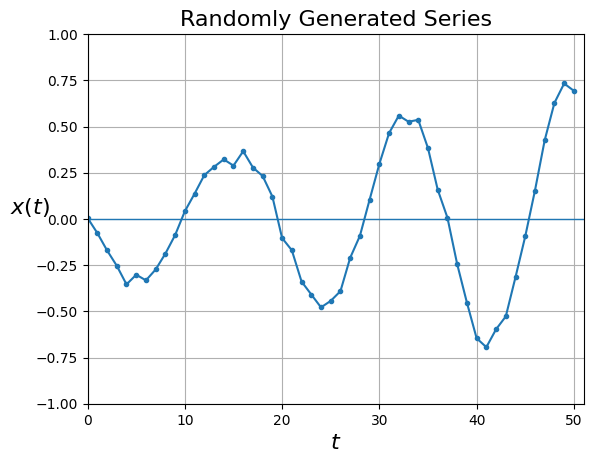

In [4]:
n_steps = 50
series = generate_time_series(10000, n_steps + 1) # 3D array of random numbers
plot_series(series[0, :, 0], title="Randomly Generated Series")

As pure usual in Data Science, time to split our data into training, testing, and validation sets. 

In [5]:
X_train, y_train = series[:7000, :n_steps], series[:7000, -1] # 2D array of random numbers
X_valid, y_valid = series[7000:9000, :n_steps], series[7000:9000, -1] # 2D array of random numbers
X_test, y_test = series[9000:, :n_steps], series[9000:, -1] # 2D array of random numbers

In [6]:
X_train.shape, y_train.shape, X_valid.shape, y_valid.shape, X_test.shape, y_test.shape

((7000, 50, 1), (7000, 1), (2000, 50, 1), (2000, 1), (1000, 50, 1), (1000, 1))

Best to have some baseline metrics before continuing, or we could end up thinking our model works great when in fact its performing worse than basic models. 

**Naive forecasting**, whereas we ask the model to predict the last value is one such simple approach.

In [7]:
y_pred = X_valid[:, -1]
np.mean(keras.losses.mean_squared_error(y_valid, y_pred))

0.019687386

Another baseline approach is with a fully connected network. So let's use  a simple Linear Regression model so that each prediction will be a linear combination of the values in the time series. 

In [8]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[50, 1]),
    keras.layers.Dense(1)
])

model.compile(loss="mse", optimizer="adam")
history = model.fit(X_train, y_train, epochs=20, validation_data=(X_valid, y_valid))
model.evaluate(X_valid, y_valid)


Epoch 1/20
219/219 [==============================] - 1s 2ms/step - loss: 0.1273 - val_loss: 0.0310
Epoch 2/20
219/219 [==============================] - 0s 986us/step - loss: 0.0213 - val_loss: 0.0156
Epoch 3/20
219/219 [==============================] - 0s 1ms/step - loss: 0.0136 - val_loss: 0.0117
Epoch 4/20
219/219 [==============================] - 0s 1ms/step - loss: 0.0110 - val_loss: 0.0099
Epoch 5/20
219/219 [==============================] - 0s 1ms/step - loss: 0.0096 - val_loss: 0.0088
Epoch 6/20
219/219 [==============================] - 0s 992us/step - loss: 0.0087 - val_loss: 0.0080
Epoch 7/20
219/219 [==============================] - 0s 1ms/step - loss: 0.0079 - val_loss: 0.0072
Epoch 8/20
219/219 [==============================] - 0s 1ms/step - loss: 0.0072 - val_loss: 0.0066
Epoch 9/20
219/219 [==============================] - 0s 990us/step - loss: 0.0067 - val_loss: 0.0061
Epoch 10/20
219/219 [==============================] - 0s 1ms/step - loss: 0.0062 - val_loss: 

0.003719138214364648

A MSE of 0.0046 is pretty good. Can RNNs beat that?

Time to create an RNN version of the model. 

In [9]:
modelRNN = keras.models.Sequential([
    keras.layers.SimpleRNN(1, input_shape=[None, 1])
])

In [10]:
modelRNN.compile(loss="mse", optimizer="adam")
historyRNN = modelRNN.fit(X_train, y_train, epochs=20, validation_data=(X_valid, y_valid))
modelRNN.evaluate(X_valid, y_valid)


Epoch 1/20
219/219 [==============================] - 2s 5ms/step - loss: 0.2247 - val_loss: 0.1412
Epoch 2/20
219/219 [==============================] - 1s 4ms/step - loss: 0.1043 - val_loss: 0.0776
Epoch 3/20
219/219 [==============================] - 1s 4ms/step - loss: 0.0707 - val_loss: 0.0623
Epoch 4/20
219/219 [==============================] - 1s 4ms/step - loss: 0.0586 - val_loss: 0.0523
Epoch 5/20
219/219 [==============================] - 1s 4ms/step - loss: 0.0500 - val_loss: 0.0449
Epoch 6/20
219/219 [==============================] - 1s 4ms/step - loss: 0.0434 - val_loss: 0.0390
Epoch 7/20
219/219 [==============================] - 1s 4ms/step - loss: 0.0383 - val_loss: 0.0346
Epoch 8/20
219/219 [==============================] - 1s 4ms/step - loss: 0.0342 - val_loss: 0.0312
Epoch 9/20
219/219 [==============================] - 1s 4ms/step - loss: 0.0309 - val_loss: 0.0281
Epoch 10/20
219/219 [==============================] - 1s 4ms/step - loss: 0.0281 - val_loss: 0.0256

0.013801910914480686

This isn't exactly better than the Naive Approach so let's try adding some layers for a *Deep RNN.*

In [11]:
modelRNN = keras.models.Sequential([
    keras.layers.SimpleRNN(20,  return_sequences=True, input_shape=[None, 1]),
    keras.layers.SimpleRNN(20, return_sequences=True),
    keras.layers.SimpleRNN(1)
])

In [12]:
modelRNN.compile(loss="mse", optimizer="adam")
historyRNN = modelRNN.fit(X_train, y_train, epochs=20, validation_data=(X_valid, y_valid))
modelRNN.evaluate(X_valid, y_valid)


Epoch 1/20
219/219 [==============================] - 5s 14ms/step - loss: 0.0265 - val_loss: 0.0053
Epoch 2/20
219/219 [==============================] - 3s 12ms/step - loss: 0.0042 - val_loss: 0.0035
Epoch 3/20
219/219 [==============================] - 3s 13ms/step - loss: 0.0034 - val_loss: 0.0030
Epoch 4/20
219/219 [==============================] - 3s 12ms/step - loss: 0.0032 - val_loss: 0.0029
Epoch 5/20
219/219 [==============================] - 3s 13ms/step - loss: 0.0031 - val_loss: 0.0028
Epoch 6/20
219/219 [==============================] - 3s 12ms/step - loss: 0.0030 - val_loss: 0.0028
Epoch 7/20
219/219 [==============================] - 3s 13ms/step - loss: 0.0030 - val_loss: 0.0029
Epoch 8/20
219/219 [==============================] - 3s 12ms/step - loss: 0.0030 - val_loss: 0.0027
Epoch 9/20
219/219 [==============================] - 3s 12ms/step - loss: 0.0029 - val_loss: 0.0028
Epoch 10/20
219/219 [==============================] - 3s 13ms/step - loss: 0.0029 - val_lo

0.002664504572749138

This beats the simple linear model!

# Forecasting Several Time Steps Ahead

We've predicted one step ahead at a time, but we can just as easily predict further by changing the target. 

First option is to use the model we already trained, make it predict the next value, then add that value to the inputs (acting as if this predicted value had acctually occured), and use the model against to predict the following value, and so on...

In [13]:
#Forecasting Several Steps Ahead

series=generate_time_series(1, n_steps+10)
X_new, Y_new = series[:, :n_steps], series[:, n_steps:]
X = X_new
for step_ahead in range(10):
    y_pred_one = model.predict(X[:, step_ahead:])[:, np.newaxis, :]
    X = np.concatenate([X, y_pred_one], axis=1)

Y_pred = X[:, n_steps:]

1/1 [==============================] - 0s 17ms/step


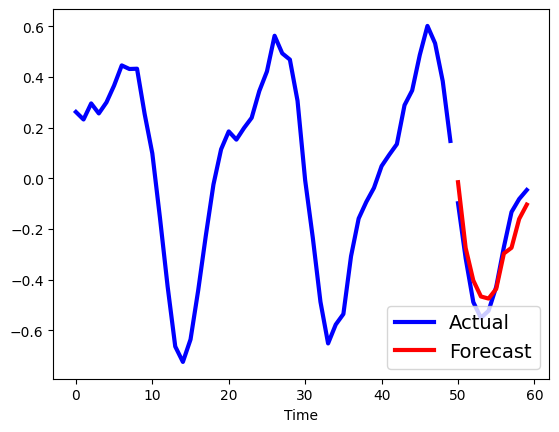

In [14]:
#Graph the results for the actual and forecasted values

plt.plot(np.arange(n_steps), X_new[0, :, 0], "b-", linewidth=3, label="Actual")
plt.plot(np.arange(n_steps, n_steps + 10), Y_new[0, :, 0], "b-", linewidth=3)
plt.plot(np.arange(n_steps, n_steps + 10), Y_pred[0, :, 0], "r-", linewidth=3, label="Forecast")
plt.xlabel("Time")
plt.legend(fontsize=14)
plt.show()


In [15]:
#score the model


Second option is to train an RNN to predict the next 10 values at once using a sequence-to-vector model.

In [16]:
seriesRNN = generate_time_series(10000, n_steps + 10)
X_train, Y_train = seriesRNN[:7000, :n_steps], seriesRNN[:7000, -10:, 0]
X_valid, Y_valid = seriesRNN[7000:9000, :n_steps], seriesRNN[7000:9000, -10:, 0]
X_test, Y_test = seriesRNN[9000:, :n_steps], seriesRNN[9000:, -10:, 0]

We just need the dense output layer to have 10 units instead of one. 

In [17]:
model = keras.models.Sequential([
    keras.layers.SimpleRNN(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.SimpleRNN(20),
    keras.layers.Dense(10)
])

In [18]:
#now easily predict the next 10 values
Y_pred = model.predict(X_new)

1/1 [==============================] - 0s 171ms/step


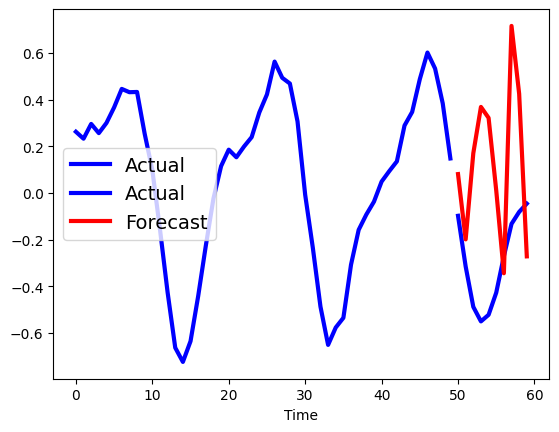

In [19]:
#graph the results for the actual and forecasted values
import matplotlib.pyplot as plt
plt.plot(np.arange(n_steps), X_new[0, :, 0], "b-", linewidth=3, label="Actual")
plt.plot(np.arange(n_steps, n_steps + 10), Y_new[0, :, 0], "b-", linewidth=3, label="Actual")
plt.plot(np.arange(n_steps, n_steps + 10), Y_pred[0, :], "r-", linewidth=3, label="Forecast")
plt.xlabel("Time")
plt.legend(fontsize=14)
plt.show()


Looks like we may have a gradient problem above. [TODO- More on exploding and vanishing gradients]

# Fighting the Unstable Gradient Problem
Mindful, RNNs aren't used that often. The more you unroll a gradient, the harder it is to train. This is known as the *vanishing/exploding gradient problem.*

Many tricks to aleviate the unstable gradient problem such as a non-satuarating activation function (e.g. ReLU) may not help. If anything, they might hurt, hence why TanH is the default. 

*Layer Normalization* often works better with RNNs. Instead of normalizing accross the batch dimension, it normalizes across the feature dimension. 

In [20]:
class LNSimpleRNNCell(keras.layers.Layer):
    def __init__(self, units, activation="tanh", **kwargs):
        super().__init__(**kwargs)
        self.state_size = units
        self.output_size = units
        self.simple_rnn_cell = keras.layers.SimpleRNNCell(units, activation=None)
        self.layer_norm = keras.layers.LayerNormalization()
        self.activation = keras.activations.get(activation)
    def call(self, inputs, states):
        outputs, new_states = self.simple_rnn_cell(inputs, states)
        norm_outputs = self.activation(self.layer_norm(outputs))
        return norm_outputs, [norm_outputs]

# TODO - Explaination of LNSimpleRNNCell

In [21]:
modeLNN= keras.models.Sequential([
    keras.layers.RNN(LNSimpleRNNCell(20), return_sequences=True, input_shape=[None, 1]),
    keras.layers.RNN(LNSimpleRNNCell(20), return_sequences=True),
    keras.layers.TimeDistributed(keras.layers.Dense(10))
])

In [22]:
#now easily predict the next 10 values
Y_pred = modelLNN.predict(X_new)


NameError: name 'modelLNN' is not defined

ValueError: x and y must have same first dimension, but have shapes (10,) and (50,)

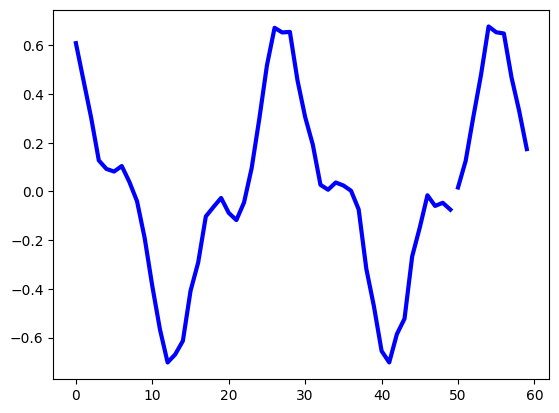

In [ ]:
#graph the results
plt.plot(np.arange(n_steps), X_new[0, :, 0], "b-", linewidth=3, label="Actual")
plt.plot(np.arange(n_steps, n_steps + 10), Y_new[0, :, 0], "b-", linewidth=3, label="Actual")
plt.plot(np.arange(n_steps, n_steps + 10), Y_pred[0, :, 0], "r-", linewidth=3, label="Forecast") #TODO Make the dimensions work
plt.xlabel("Time")
plt.legend(fontsize=14)
plt.show()


# Tackling Short Term Memory Problems
Due to the transformations data goes through while traversing an RNN, some information is lost with each time step. This can be a problem. 

Imagine Dory the fish trying to translate a long sentence; by the time she's finished reading it, she forgot how it began. 

To tackle this memory loss problem, various *long short-term memory* cells have been introduced. Apparently so successful, that basic cells aren't really used much anymore. 

In keras, you simply use the built in LSTM layer instead of the simple RNN layer. 

In [ ]:
modelLSTM = keras.models.Sequential([
    keras.layers.LSTM(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.LSTM(20, return_sequences=True),
    keras.layers.TimeDistributed(keras.layers.Dense(10))
])


In [ ]:
modelLSTM.compile(loss="mse", optimizer="adam")

1/1 [==============================] - 0s 20ms/step


ValueError: x and y must have same first dimension, but have shapes (0,) and (10,)

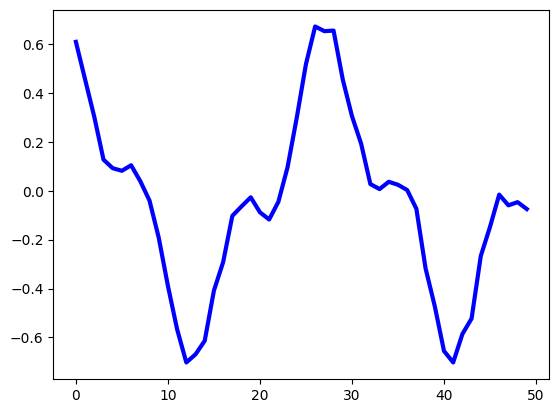

In [ ]:
#predict the next 10 values and graph the results  
Y_pred = modelLSTM.predict(X_new)
plt.plot(np.arange(n_steps), X_new[0, :, 0], "b-", linewidth=3, label="Actual")
plt.plot(np.arange(n_steps, n_steps), Y_new[0, :, 0], "b-", linewidth=3, label="Actual")
plt.plot(np.arange(n_steps, n_steps), Y_pred[0, :, 0], "r-", linewidth=3, label="Forecast") 
plt.xlabel("Time")
plt.legend(fontsize=14)
plt.show()


In [ ]:
#score the model
modelLSTM.evaluate(X_valid, Y_valid)

InvalidArgumentError: Graph execution error:

Detected at node 'mean_squared_error/SquaredDifference' defined at (most recent call last):
    File "c:\Users\David\anaconda3\lib\runpy.py", line 193, in _run_module_as_main
      "__main__", mod_spec)
    File "c:\Users\David\anaconda3\lib\runpy.py", line 85, in _run_code
      exec(code, run_globals)
    File "C:\Users\David\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py", line 17, in <module>
      app.launch_new_instance()
    File "C:\Users\David\AppData\Roaming\Python\Python37\site-packages\traitlets\config\application.py", line 1041, in launch_instance
      app.start()
    File "C:\Users\David\AppData\Roaming\Python\Python37\site-packages\ipykernel\kernelapp.py", line 712, in start
      self.io_loop.start()
    File "C:\Users\David\AppData\Roaming\Python\Python37\site-packages\tornado\platform\asyncio.py", line 215, in start
      self.asyncio_loop.run_forever()
    File "c:\Users\David\anaconda3\lib\asyncio\base_events.py", line 538, in run_forever
      self._run_once()
    File "c:\Users\David\anaconda3\lib\asyncio\base_events.py", line 1782, in _run_once
      handle._run()
    File "c:\Users\David\anaconda3\lib\asyncio\events.py", line 88, in _run
      self._context.run(self._callback, *self._args)
    File "C:\Users\David\AppData\Roaming\Python\Python37\site-packages\ipykernel\kernelbase.py", line 510, in dispatch_queue
      await self.process_one()
    File "C:\Users\David\AppData\Roaming\Python\Python37\site-packages\ipykernel\kernelbase.py", line 499, in process_one
      await dispatch(*args)
    File "C:\Users\David\AppData\Roaming\Python\Python37\site-packages\ipykernel\kernelbase.py", line 406, in dispatch_shell
      await result
    File "C:\Users\David\AppData\Roaming\Python\Python37\site-packages\ipykernel\kernelbase.py", line 730, in execute_request
      reply_content = await reply_content
    File "C:\Users\David\AppData\Roaming\Python\Python37\site-packages\ipykernel\ipkernel.py", line 387, in do_execute
      cell_id=cell_id,
    File "C:\Users\David\AppData\Roaming\Python\Python37\site-packages\ipykernel\zmqshell.py", line 528, in run_cell
      return super().run_cell(*args, **kwargs)
    File "C:\Users\David\AppData\Roaming\Python\Python37\site-packages\IPython\core\interactiveshell.py", line 2976, in run_cell
      raw_cell, store_history, silent, shell_futures, cell_id
    File "C:\Users\David\AppData\Roaming\Python\Python37\site-packages\IPython\core\interactiveshell.py", line 3030, in _run_cell
      return runner(coro)
    File "C:\Users\David\AppData\Roaming\Python\Python37\site-packages\IPython\core\async_helpers.py", line 78, in _pseudo_sync_runner
      coro.send(None)
    File "C:\Users\David\AppData\Roaming\Python\Python37\site-packages\IPython\core\interactiveshell.py", line 3258, in run_cell_async
      interactivity=interactivity, compiler=compiler, result=result)
    File "C:\Users\David\AppData\Roaming\Python\Python37\site-packages\IPython\core\interactiveshell.py", line 3473, in run_ast_nodes
      if (await self.run_code(code, result,  async_=asy)):
    File "C:\Users\David\AppData\Roaming\Python\Python37\site-packages\IPython\core\interactiveshell.py", line 3553, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "C:\Users\David\AppData\Local\Temp\ipykernel_45356\3037006749.py", line 2, in <module>
      modelLSTM.evaluate(X_valid, Y_valid)
    File "C:\Users\David\AppData\Roaming\Python\Python37\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\David\AppData\Roaming\Python\Python37\site-packages\keras\engine\training.py", line 2040, in evaluate
      tmp_logs = self.test_function(iterator)
    File "C:\Users\David\AppData\Roaming\Python\Python37\site-packages\keras\engine\training.py", line 1820, in test_function
      return step_function(self, iterator)
    File "C:\Users\David\AppData\Roaming\Python\Python37\site-packages\keras\engine\training.py", line 1804, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\David\AppData\Roaming\Python\Python37\site-packages\keras\engine\training.py", line 1792, in run_step
      outputs = model.test_step(data)
    File "C:\Users\David\AppData\Roaming\Python\Python37\site-packages\keras\engine\training.py", line 1758, in test_step
      self.compute_loss(x, y, y_pred, sample_weight)
    File "C:\Users\David\AppData\Roaming\Python\Python37\site-packages\keras\engine\training.py", line 1083, in compute_loss
      y, y_pred, sample_weight, regularization_losses=self.losses
    File "C:\Users\David\AppData\Roaming\Python\Python37\site-packages\keras\engine\compile_utils.py", line 265, in __call__
      loss_value = loss_obj(y_t, y_p, sample_weight=sw)
    File "C:\Users\David\AppData\Roaming\Python\Python37\site-packages\keras\losses.py", line 152, in __call__
      losses = call_fn(y_true, y_pred)
    File "C:\Users\David\AppData\Roaming\Python\Python37\site-packages\keras\losses.py", line 284, in call
      return ag_fn(y_true, y_pred, **self._fn_kwargs)
    File "C:\Users\David\AppData\Roaming\Python\Python37\site-packages\keras\losses.py", line 1500, in mean_squared_error
      return backend.mean(tf.math.squared_difference(y_pred, y_true), axis=-1)
Node: 'mean_squared_error/SquaredDifference'
Incompatible shapes: [32,10] vs. [32,50,10]
	 [[{{node mean_squared_error/SquaredDifference}}]] [Op:__inference_test_function_323130]

In [ ]:
model = keras.models.Sequential()
model.add(keras.layers.InputLayer(input_shape=[None, 1]))
for rate in (1, 2, 4, 8) * 2:
    model.add(keras.layers.Conv1D(filters=20, kernel_size=2, padding="causal", activation="relu", dilation_rate=rate))  
    model.add(keras.layers.Conv1D(filters=10, kernel_size=1))
    model.compile(loss="mse", optimizer="adam")
history = model.fit(X_train, Y_train, epochs=20, validation_data=(X_valid, Y_valid))

Epoch 1/20


InvalidArgumentError: Graph execution error:

Detected at node 'gradient_tape/mean_squared_error/BroadcastGradientArgs' defined at (most recent call last):
    File "c:\Users\David\anaconda3\lib\runpy.py", line 193, in _run_module_as_main
      "__main__", mod_spec)
    File "c:\Users\David\anaconda3\lib\runpy.py", line 85, in _run_code
      exec(code, run_globals)
    File "C:\Users\David\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py", line 17, in <module>
      app.launch_new_instance()
    File "C:\Users\David\AppData\Roaming\Python\Python37\site-packages\traitlets\config\application.py", line 1041, in launch_instance
      app.start()
    File "C:\Users\David\AppData\Roaming\Python\Python37\site-packages\ipykernel\kernelapp.py", line 712, in start
      self.io_loop.start()
    File "C:\Users\David\AppData\Roaming\Python\Python37\site-packages\tornado\platform\asyncio.py", line 215, in start
      self.asyncio_loop.run_forever()
    File "c:\Users\David\anaconda3\lib\asyncio\base_events.py", line 538, in run_forever
      self._run_once()
    File "c:\Users\David\anaconda3\lib\asyncio\base_events.py", line 1782, in _run_once
      handle._run()
    File "c:\Users\David\anaconda3\lib\asyncio\events.py", line 88, in _run
      self._context.run(self._callback, *self._args)
    File "C:\Users\David\AppData\Roaming\Python\Python37\site-packages\ipykernel\kernelbase.py", line 510, in dispatch_queue
      await self.process_one()
    File "C:\Users\David\AppData\Roaming\Python\Python37\site-packages\ipykernel\kernelbase.py", line 499, in process_one
      await dispatch(*args)
    File "C:\Users\David\AppData\Roaming\Python\Python37\site-packages\ipykernel\kernelbase.py", line 406, in dispatch_shell
      await result
    File "C:\Users\David\AppData\Roaming\Python\Python37\site-packages\ipykernel\kernelbase.py", line 730, in execute_request
      reply_content = await reply_content
    File "C:\Users\David\AppData\Roaming\Python\Python37\site-packages\ipykernel\ipkernel.py", line 387, in do_execute
      cell_id=cell_id,
    File "C:\Users\David\AppData\Roaming\Python\Python37\site-packages\ipykernel\zmqshell.py", line 528, in run_cell
      return super().run_cell(*args, **kwargs)
    File "C:\Users\David\AppData\Roaming\Python\Python37\site-packages\IPython\core\interactiveshell.py", line 2976, in run_cell
      raw_cell, store_history, silent, shell_futures, cell_id
    File "C:\Users\David\AppData\Roaming\Python\Python37\site-packages\IPython\core\interactiveshell.py", line 3030, in _run_cell
      return runner(coro)
    File "C:\Users\David\AppData\Roaming\Python\Python37\site-packages\IPython\core\async_helpers.py", line 78, in _pseudo_sync_runner
      coro.send(None)
    File "C:\Users\David\AppData\Roaming\Python\Python37\site-packages\IPython\core\interactiveshell.py", line 3258, in run_cell_async
      interactivity=interactivity, compiler=compiler, result=result)
    File "C:\Users\David\AppData\Roaming\Python\Python37\site-packages\IPython\core\interactiveshell.py", line 3473, in run_ast_nodes
      if (await self.run_code(code, result,  async_=asy)):
    File "C:\Users\David\AppData\Roaming\Python\Python37\site-packages\IPython\core\interactiveshell.py", line 3553, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "C:\Users\David\AppData\Local\Temp\ipykernel_45356\3590789998.py", line 7, in <module>
      history = model.fit(X_train, Y_train, epochs=20, validation_data=(X_valid, Y_valid))
    File "C:\Users\David\AppData\Roaming\Python\Python37\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\David\AppData\Roaming\Python\Python37\site-packages\keras\engine\training.py", line 1650, in fit
      tmp_logs = self.train_function(iterator)
    File "C:\Users\David\AppData\Roaming\Python\Python37\site-packages\keras\engine\training.py", line 1249, in train_function
      return step_function(self, iterator)
    File "C:\Users\David\AppData\Roaming\Python\Python37\site-packages\keras\engine\training.py", line 1233, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\David\AppData\Roaming\Python\Python37\site-packages\keras\engine\training.py", line 1222, in run_step
      outputs = model.train_step(data)
    File "C:\Users\David\AppData\Roaming\Python\Python37\site-packages\keras\engine\training.py", line 1027, in train_step
      self.optimizer.minimize(loss, self.trainable_variables, tape=tape)
    File "C:\Users\David\AppData\Roaming\Python\Python37\site-packages\keras\optimizers\optimizer_experimental\optimizer.py", line 526, in minimize
      grads_and_vars = self.compute_gradients(loss, var_list, tape)
    File "C:\Users\David\AppData\Roaming\Python\Python37\site-packages\keras\optimizers\optimizer_experimental\optimizer.py", line 259, in compute_gradients
      grads = tape.gradient(loss, var_list)
Node: 'gradient_tape/mean_squared_error/BroadcastGradientArgs'
Incompatible shapes: [32,50,10] vs. [32,10]
	 [[{{node gradient_tape/mean_squared_error/BroadcastGradientArgs}}]] [Op:__inference_train_function_333192]